# Predicting Supply Chain Delays with Machine Learning

## Objective:

This project aims to predict supply chain shipping delays using real-world data. 
        I addressed class imbalance with SMOTE, trained multiple ML models, and applied hyperparameter tuning.
        (XGBoost, Random Forest, CatBoost).

## 1. Loaded Data & Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, cohen_kappa_score, matthews_corrcoef, 
                             confusion_matrix, roc_curve, auc, precision_recall_curve)

file_path = "C:/Users/colby/OneDrive/Documents/SCMS_selected_features.csv"
df = pd.read_csv(file_path)
df.drop(columns=["Fulfill_Via_Direct_Drop"], inplace=True)
df = df[df["Processing_Time_(Days)"] >= 0]

X = df.drop(columns=["Delayed"])
y = df["Delayed"] 
selected_features_rf = X.columns

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10319 entries, 0 to 10323
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Line_Item_Value         10319 non-null  float64
 1   Weight_(Kilograms)      10319 non-null  float64
 2   Freight_Cost_(USD)      10319 non-null  float64
 3   Processing_Time_(Days)  10319 non-null  float64
 4   Freight_Cost_per_KG     10319 non-null  float64
 5   Shipment_Mode_Truck     10319 non-null  int64  
 6   Country_Congo_DRC       10319 non-null  int64  
 7   Country_CÃ´te_dIvoire   10319 non-null  int64  
 8   Country_Mozambique      10319 non-null  int64  
 9   Country_Nigeria         10319 non-null  int64  
 10  Country_Uganda          10319 non-null  int64  
 11  Country_Zambia          10319 non-null  int64  
 12  Delivery_Quarter_1      10319 non-null  int64  
 13  Delivery_Quarter_2      10319 non-null  int64  
 14  Delivery_Quarter_3      10319 non-null

(None,
    Line_Item_Value  Weight_(Kilograms)  Freight_Cost_(USD)  \
 0            551.0                13.0              780.34   
 1           6200.0               358.0             4521.50   
 2          40000.0               171.0             1653.78   
 3         127360.8              1855.0            16007.06   
 4         121600.0              7590.0            45450.08   
 
    Processing_Time_(Days)  Freight_Cost_per_KG  Shipment_Mode_Truck  \
 0                    24.0            60.026154                    0   
 1                    24.0            12.629888                    0   
 2                    24.0             9.671228                    0   
 3                    24.0             8.629143                    0   
 4                    24.0             5.988153                    0   
 
    Country_Congo_DRC  Country_CÃ´te_dIvoire  Country_Mozambique  \
 0                  0                      1                   0   
 1                  0                      

In [3]:
df.head()
print(f"Min Processing Time in Train Set: {X['Processing_Time_(Days)'].min()}")
print(f"Min Processing Time in Test Set: {X['Processing_Time_(Days)'].min()}")

Min Processing Time in Train Set: 0.0
Min Processing Time in Test Set: 0.0


In [4]:
print("Has Inf values:", np.isinf(X[selected_features_rf]).sum().sum())
print("Has NaN values:", np.isnan(X[selected_features_rf]).sum().sum())
X[selected_features_rf] = X[selected_features_rf].replace([np.inf, -np.inf], np.nan)
X[selected_features_rf] = X[selected_features_rf].fillna(X[selected_features_rf].median())

Has Inf values: 1
Has NaN values: 0


## 2. Applied SMOTE to Address Class Imbalance

In [5]:
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X[selected_features_rf], y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Train set shape: (10228, 17) (10228,)
Test set shape: (4384, 17) (4384,)


## 3. Trained Models and Applied Hyperparameter Tuning

In [6]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
}

param_grids = {
    "Random Forest": {
         "n_estimators": [100, 200],
    "max_depth": [12, 15],  
    "min_samples_split": [5, 10],  
    "min_samples_leaf": [3, 5],  
    "max_features": ["sqrt"] 
    },
    "XGBoost": {
        "n_estimators": [100, 150],
    "max_depth": [3, 4],  
    "learning_rate": [0.05, 0.1], 
    "subsample": [0.7, 0.8], 
    "colsample_bytree": [0.7 ,0.8],
    "reg_alpha": [0.1, 0.5],
    "reg_lambda": [0.1, 0.5]
    },
    "CatBoost": {
         "iterations": [300, 500],
    "depth": [4, 5],  
    "learning_rate": [0.05, 0.1], 
    "l2_leaf_reg": [10, 20], 
      "bagging_temperature": [1, 2]
    }
}

In [7]:
best_models_recall = {}

for name, model in models.items():
    print(f" Tuning {name} for Recall")

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=10,
        scoring="recall",
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)

    best_models_recall[name] = search.best_estimator_
    
    print(f"Best Recall Model for {name}: {search.best_params_}\n")

 Tuning Random Forest for Recall
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Recall Model for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 15}

 Tuning XGBoost for Recall
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\colby\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:17:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Recall Model for XGBoost: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

 Tuning CatBoost for Recall
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Recall Model for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 500, 'depth': 5, 'bagging_temperature': 2}



In [8]:
best_models_f1 = {}

for name, model in best_models_recall.items():
    print(f" Tuning {name} for F1 Score")

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=10,  
        scoring="f1",
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)

    best_models_f1[name] = search.best_estimator_
    
    print(f" Best F1 Model for {name}: {search.best_params_}\n")


 Tuning Random Forest for F1 Score
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Best F1 Model for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 15}

 Tuning XGBoost for F1 Score
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\colby\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:17:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Best F1 Model for XGBoost: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

 Tuning CatBoost for F1 Score
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Best F1 Model for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 500, 'depth': 5, 'bagging_temperature': 2}



## 4. Model Comparison w/ Both Training & Test Set Results

In [9]:
results = []

def evaluate_model_df(name, model, X_train, y_train, X_test, y_test):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    threshold = 0.375
    y_train_pred_adjusted = (y_train_proba >= threshold).astype(int)
    y_test_pred_adjusted = (y_test_proba >= threshold).astype(int)

    train_accuracy = accuracy_score(y_train, y_train_pred_adjusted)
    train_precision = precision_score(y_train, y_train_pred_adjusted)
    train_recall = recall_score(y_train, y_train_pred_adjusted)
    train_f1 = f1_score(y_train, y_train_pred_adjusted)

    test_accuracy = accuracy_score(y_test, y_test_pred_adjusted)
    test_precision = precision_score(y_test, y_test_pred_adjusted)
    test_recall = recall_score(y_test, y_test_pred_adjusted)
    test_f1 = f1_score(y_test, y_test_pred_adjusted)

    results.append({
        "Model": name,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1 Score": train_f1,
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1 Score": test_f1
    })

for name, model in best_models_f1.items():
    evaluate_model_df(name, model, X_train, y_train, X_test, y_test)

results_df = pd.DataFrame(results)

results_df

,Model,Train Accuracy,Train Precision,Train Recall,Train F1 Score,Test Accuracy,Test Precision,Test Recall,Test F1 Score
0,Random Forest,0.926183,0.878937,0.931421,0.904418,0.866788,0.805652,0.849757,0.827117
1,XGBoost,0.886488,0.834920,0.869100,0.851667,0.864051,0.805718,0.840024,0.822513
2,CatBoost,0.922174,0.888718,0.905867,0.897211,0.876141,0.821742,0.855231,0.838152


## 5. Confusion Matrix, AUROC Curve, and Precision-Recall Curve for All Models

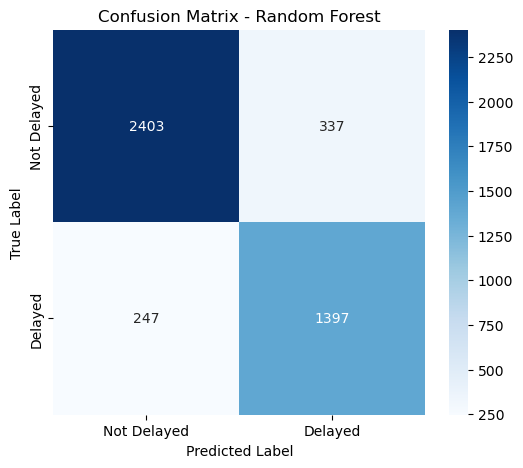

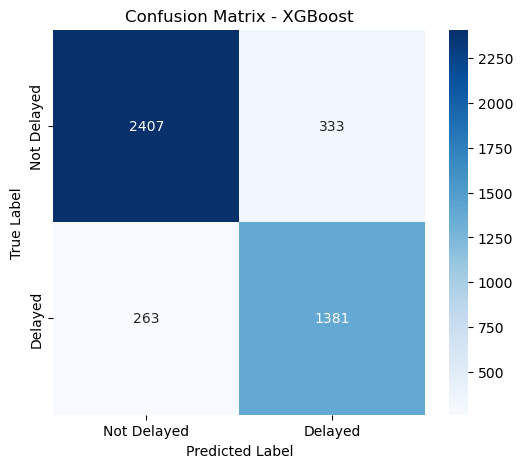

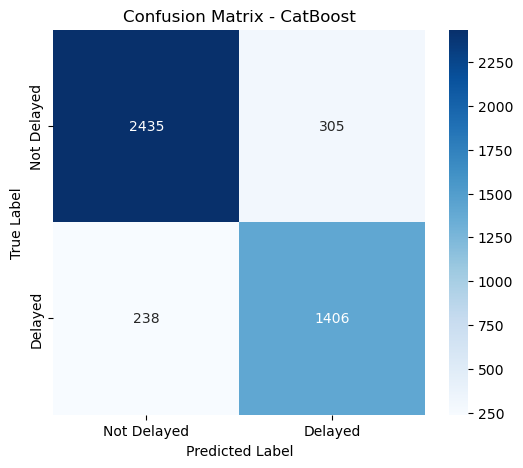

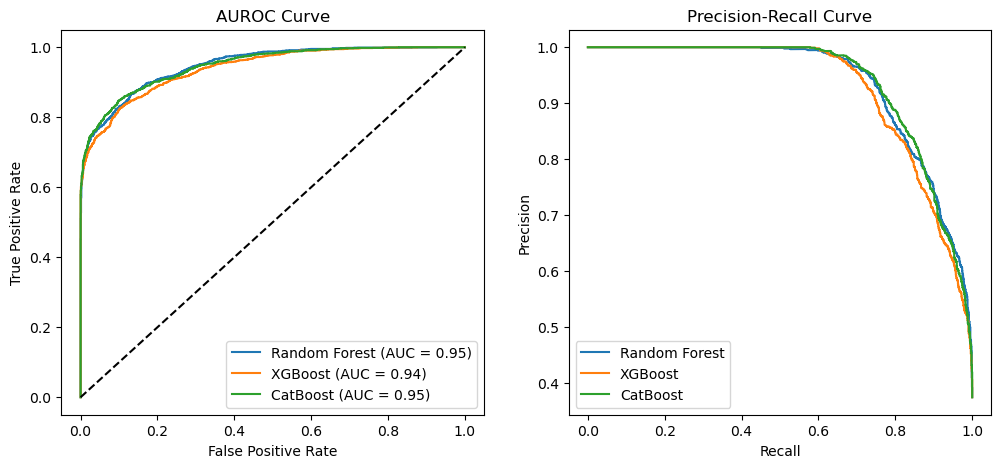

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Delayed", "Delayed"], yticklabels=["Not Delayed", "Delayed"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

def plot_roc_pr_curves(models, X_test, y_test):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in models.items():
        y_test_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")  
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    for name, model in models.items():
        y_test_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
        plt.plot(recall, precision, label=f"{name}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.show()

for name, model in best_models_f1.items():
    y_test_proba = model.predict_proba(X_test)[:, 1]
    threshold = 0.375
    y_test_pred_adjusted = (y_test_proba >= threshold).astype(int)

    plot_confusion_matrix(y_test, y_test_pred_adjusted, name)

plot_roc_pr_curves(best_models_f1, X_test, y_test)

## 6. Model Interpretability Using SHAP (XGBoost)

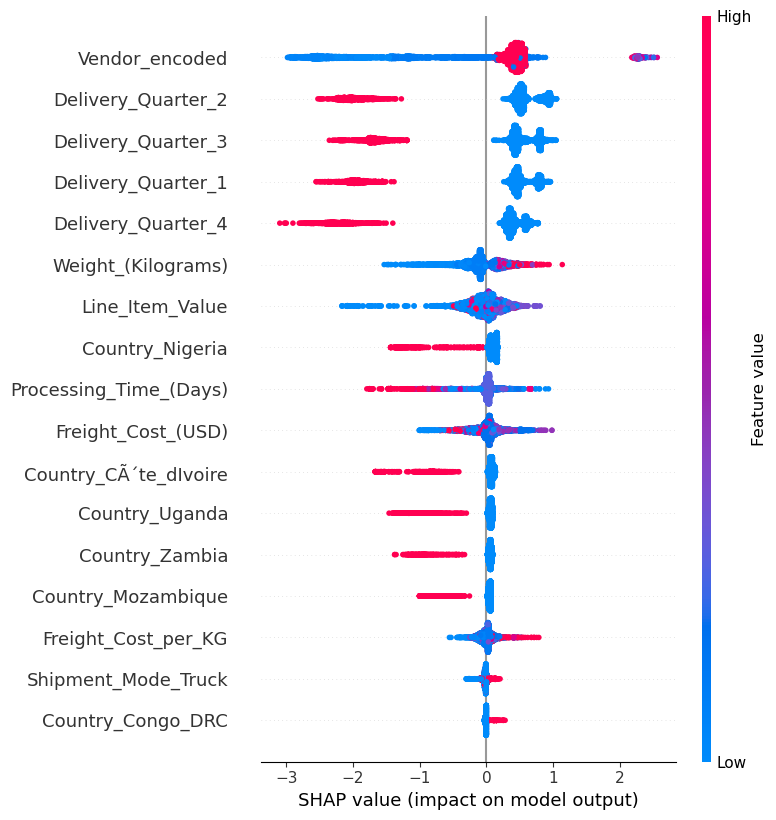

In [11]:
import shap
best_model = best_models_f1["XGBoost"]

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

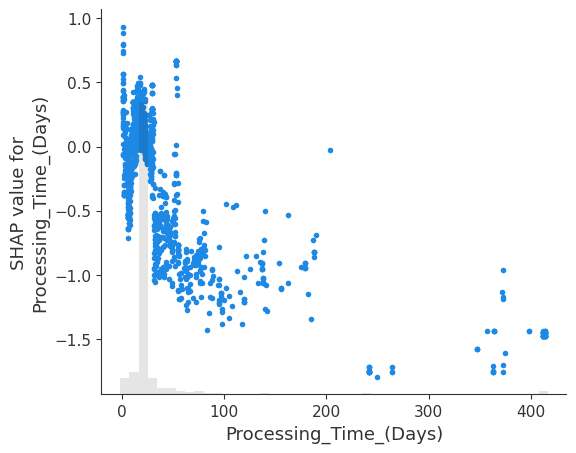

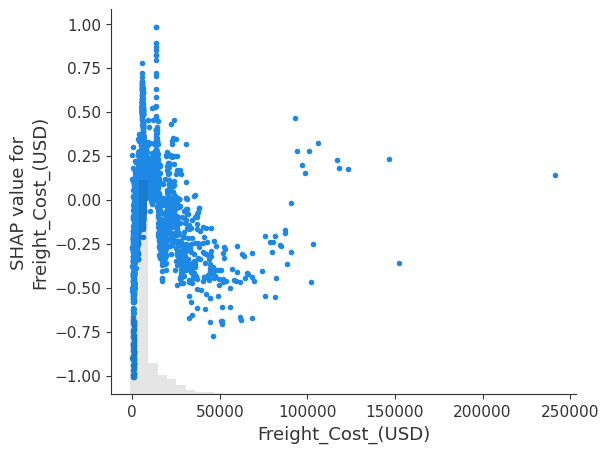

In [12]:
shap.plots.scatter(shap_values[:, "Processing_Time_(Days)"])
shap.plots.scatter(shap_values[:, "Freight_Cost_(USD)"])

## 7. Feature Importance Using Random Forest

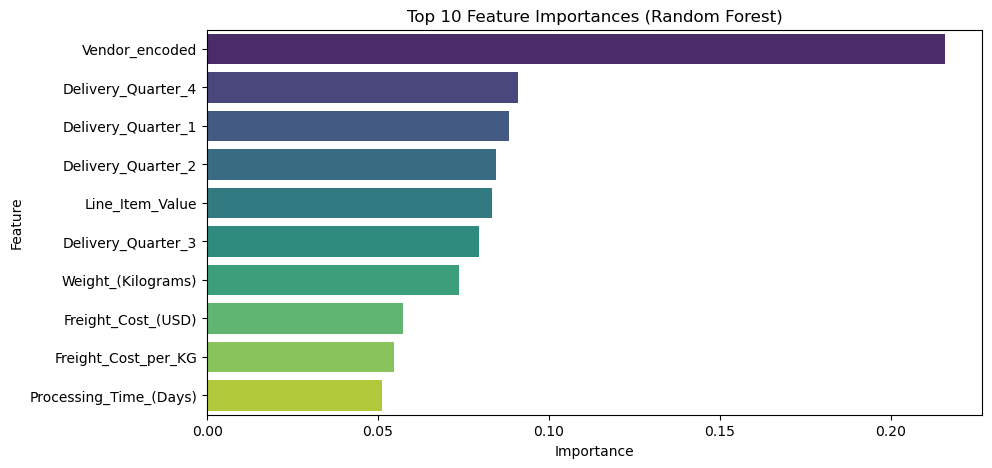

In [16]:

importances = best_models_f1["Random Forest"].feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:10], palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()
